In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.version.cuda)

True
1
11.7


In [2]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [2]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [456]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

Exception ignored in: '_pydevd_frame_eval.pydevd_frame_evaluator.get_bytecode_while_frame_eval_39'
Traceback (most recent call last):
  File "_pydevd_frame_eval/pydevd_frame_evaluator.pyx", line 258, in _pydevd_frame_eval.pydevd_frame_evaluator.get_func_code_info
  File "C:\Users\SSD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\debugpy\_vendored\pydevd\pydevd_file_utils.py", line 885, in get_abs_path_real_path_and_base_from_frame
    ret = get_abs_path_real_path_and_base_from_file(f)
  File "C:\Users\SSD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\debugpy\_vendored\pydevd\pydevd_file_utils.py", line 852, in get_abs_path_real_path_and_base_from_file
    abs_path, canonical_normalized_filename = _abs_and_canonical_path(f)
  File "C:\Users\SSD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local

SystemError: <function VendorImporter.find_spec at 0x000001B3A9121900> returned NULL without setting an exception

In [3]:
# images_dir = "/content/drive/MyDrive/IA/COVID-19_Radiography_Dataset/dataset_images/"
# masks_dir = "/content/drive/MyDrive/IA/COVID-19_Radiography_Dataset/dataset_masks/"

images_dir = "./COVID-19_Radiography_Dataset/dataset_images/"
masks_dir = "./COVID-19_Radiography_Dataset/dataset_masks/"

In [4]:
def Show_imgs(imgs, name,  size = 3, color = True):
  color_m ='jet'
  if color == False:
    color_m ='gray'
  print('Label: ' + name) # can add a dict here
  img_numbers = imgs.shape[0]
  rows = cols = math.ceil(np.sqrt(img_numbers))
  
  fig = plt.figure(figsize=(rows*size, cols*size))
  for i in range(0, rows*cols):
    fig.add_subplot(rows, cols,i+1)
    if i<img_numbers:
      plt.imshow(imgs[i].detach(), cmap = 'gray')
  plt.show()

In [5]:
class MaskedDataset(torch.utils.data.Dataset):
    def __init__(self, datasetA, datasetB):
        self.datasetA = datasetA
        self.datasetB = datasetB
        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        return xA, xB
    
    def __len__(self):
        return len(self.datasetA)

Loading Dataset...
Loaded Dataset!
Dataset ImageFolder
    Number of datapoints: 21165
    Root location: ./COVID-19_Radiography_Dataset/dataset_images/
    StandardTransform
Transform: Compose(
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=None)
               Grayscale(num_output_channels=1)
               RandomAdjustSharpness(sharpness_factor=20,p=1)
               ToTensor()
           )
<class 'torchvision.datasets.folder.ImageFolder'>
Label: 0


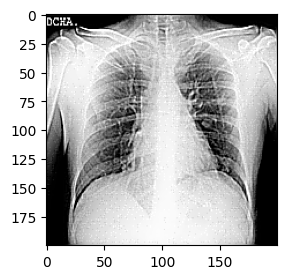

Label: 0


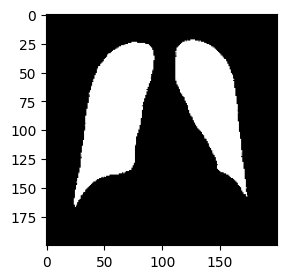

In [103]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np

import multiprocessing as mp

size = 200

transform = transforms.Compose([transforms.Resize((size, size)), 
                                transforms.Grayscale(num_output_channels=1),
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.RandomAdjustSharpness(20, p=1), 
                                transforms.ToTensor()]) 

print("Loading Dataset...")
dataset = ImageFolder(root=images_dir, transform=transform)
masks = ImageFolder(root=masks_dir, transform=transform)
print("Loaded Dataset!")

print(dataset)
print(type(dataset))

img, label = dataset[3]
Show_imgs(img, str(label))
img, label = masks[3]
Show_imgs(img, str(label))

# generate & shuffle indices
N = len(dataset)
indices = np.arange(N)
indices = np.random.RandomState(seed=41).permutation(indices)

# select train/test/val using 70,20,10
train_indices = indices[:int(0.7*N)]
val_indices = indices[int(0.7*N):int(0.90*N)]
test_indices = indices[int(0.90*N):]

# subsets based on permutated index
train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

train_set_mask = torch.utils.data.Subset(masks, train_indices)
val_set_mask = torch.utils.data.Subset(masks, val_indices)
test_set_mask = torch.utils.data.Subset(masks, test_indices)

# combined dataset of image and mask
train_masked_set = MaskedDataset(train_set, train_set_mask)
val_masked_set = MaskedDataset(val_set, val_set_mask)
test_masked_set = MaskedDataset(test_set, test_set_mask)

# Loaders 
batch_size = 32

train_loader = DataLoader(dataset=train_masked_set, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True) # mp.cpu_count()
val_loader = DataLoader(dataset=val_masked_set, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True) # mp.cpu_count()
test_loader = DataLoader(dataset=test_masked_set, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True) # mp.cpu_count()

In [28]:
import os
print(os.listdir(images_dir))
cpt = sum([len(files) for r, d, files in os.walk(images_dir)]) # MISSING FILES!
print(cpt)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
21165


In [29]:
print(dataset.class_to_idx)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
print(idx_to_class)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}


Label: 0


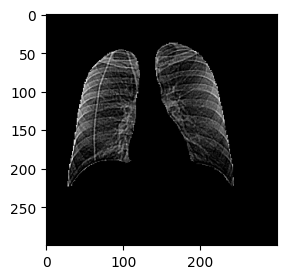

Label: 2


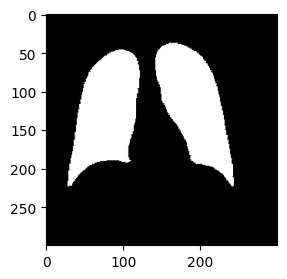

In [33]:
(images, labels), (images_mask, labels_mask) = train_masked_set[991]
Show_imgs(images*images_mask, str(label))
Show_imgs(images_mask, str(labels_mask))

In [10]:
print(len(dataset))
print(len(masks))

21165
21165


In [11]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

14815
4233
2117


Label: 2


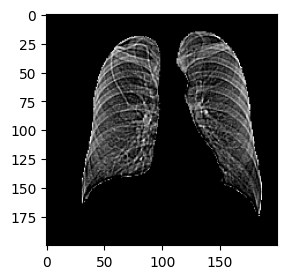

Label: 2, layer 1


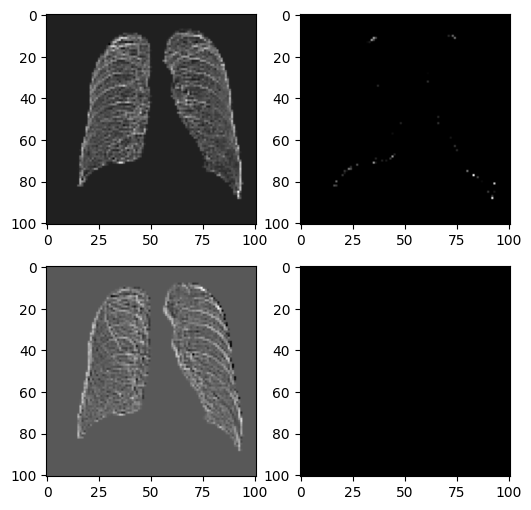

si
torch.Size([1, 4, 101, 101])
torch.Size([1, 40804])
Label: layer 1 weight


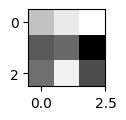

Label: layer 1 weight


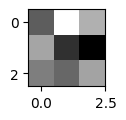

Label: layer 1 weight


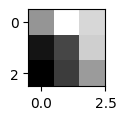

Label: layer 1 weight


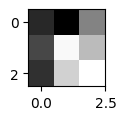

In [129]:
img, label = train_set[0]
img = img * train_set_mask[0][0]
Show_imgs(img, str(label))

img = img.unsqueeze(0)

layer1 = nn.Sequential( nn.Conv2d(1,4,3,1,2) , nn.ReLU(), nn.MaxPool2d(2,2))

out = layer1(img)
Show_imgs(out[0], str(label) + ", " + "layer 1")

print("si")
print(out.shape)

out = out.reshape(out.size(0),-1)
print(out.shape)

for i in range(4):
  Show_imgs(layer1[0].weight[i],"layer 1 weight", 1)
#Show_imgs(layer1[0].weight,"layer 1 weight", 1)


In [130]:
l1_c = 8
l2_c = 16
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=l1_c, kernel_size=3, stride=1, padding=2
            ),
            # nn.BatchNorm2d(l1_c),
            nn.ReLU(),
            nn.Dropout(0.25),
            # nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=l1_c, out_channels=l2_c, kernel_size=3, stride=1, padding=2
            ),
            # nn.BatchNorm2d(l2_c),
            nn.ReLU(),
            nn.Dropout(0.25),
            # nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
       
        # self.fc1 = nn.Sequential(nn.LazyLinear(num_classes), nn.Softmax(1))
        self.fc1 = nn.Sequential(nn.LazyLinear(num_classes))

    # Second method: (((W - K + 2P)/S) + 1)
    #         Here W = Input size
    #         K = Filter size
    #         S = Stride
    #         P = Padding

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out


In [40]:
# pre cache data from loader
i=0
print(N/batch_size)
for ((images, labels), (images_mask, labels_mask)) in train_loader:
  print("|", end ="")
  i+=1

661.40625
|||||||||

KeyboardInterrupt: 

In [36]:
import multiprocessing as mp
mp.cpu_count()

8

In [46]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [140]:
train_indices_small = np.random.RandomState(seed=41).permutation(train_indices)
train_indices_small = train_indices_small[:int(0.2*len(train_indices_small))]
val_indices_small = np.random.RandomState(seed=41).permutation(val_indices)
val_indices_small = val_indices_small[:int(0.2*len(val_indices_small))]
test_indices_small = np.random.RandomState(seed=41).permutation(test_indices)
test_indices_small = test_indices_small[:int(0.2*len(test_indices_small))]

train_masked_set_small = MaskedDataset(torch.utils.data.Subset(dataset, train_indices_small), torch.utils.data.Subset(masks, train_indices_small))
val_masked_set_small = MaskedDataset(torch.utils.data.Subset(dataset, val_indices_small), torch.utils.data.Subset(masks, val_indices_small))
test_masked_set_small = MaskedDataset(torch.utils.data.Subset(dataset, test_indices_small), torch.utils.data.Subset(masks, test_indices_small))

train_loader_small = DataLoader(dataset=train_masked_set_small, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True) # mp.cpu_count()
val_loader_small = DataLoader(dataset=val_masked_set_small, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True) # mp.cpu_count()
test_loader_small = DataLoader(dataset=test_masked_set_small, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True) # mp.cpu_count()

In [132]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
import torch.nn.functional as F


def train(model, optimizer, loss_fn, num_epochs):

  # train the model
  total_step = len(train_loader_small)
  print("total steps:", total_step)
  print("epochs:", num_epochs)

  epoch_train_loss = []
  epoch_val_loss = []
  
  print("Training Starting...")
  for epoch in range(num_epochs):
    pl.clf()

    last_loss = 0
    last_vloss = 0
    print("\nStarting epoch:", epoch)
    
    # model.train(True)
    len_loss = 0
    for i, ((images, labels), (images_mask, _)) in enumerate(train_loader_small):
      # to device
      masked_images = torch.mul(images, images_mask) # with mask
      # masked_images = images # without mask

      # for i in range(batch_size):
      #   masked_images[i] -= torch.min(masked_images[i])
      #   masked_images[i] /= torch.max(masked_images[i])
      
      masked_images = masked_images.to(device)
      labels = labels.to(device)
      # print(masked_images.permute(0,1,2,3)[0].shape)
      # plt.imshow(transforms.ToPILImage()(masked_images.permute(0,1,2,3)[0]), cmap='gray')
      # plt.show()

      # forward
      output = model(masked_images)
      loss   = loss_fn(output, labels)
      
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # add up loss
      last_loss += (loss.item())
      len_loss += 1
          
      if (i+1) % 100 == 0 or i == 0:
              print ('\nEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, (last_loss)/(len_loss)))
      print("|", end ="")

    # model.train(False)
    epoch_train_loss.append((last_loss)/(len_loss))
    pl.plot(range(len(epoch_train_loss)), epoch_train_loss, label="train loss") # plot
    
    # model.eval()
    # with torch.no_grad():
    len_vloss = 0
    for i, ((vimages, vlabels), (vimages_mask, _)) in enumerate(val_loader_small):
      vmasked_images = torch.mul(vimages, vimages_mask) # with mask 
      # vmasked_images = vimages # without mask

      # for i in range(batch_size):
      #   vmasked_images[i] -= torch.min(vmasked_images[i])
      #   vmasked_images[i] /= torch.max(vmasked_images[i])

      vmasked_images = vmasked_images.to(device)
      vlabels = vlabels.to(device)
      output = model(vmasked_images)
      vloss   = loss_fn(output, vlabels)
      last_vloss += (vloss.item())
      print(vloss.item())
      len_vloss+=1
      if (i+1) % 100 == 0 or i == 0:
              print ('\nVal Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, (last_vloss)/(len_vloss)))
      print("|", end ="")

    epoch_val_loss.append((last_vloss)/(len_vloss))
    
    pl.plot(range(len(epoch_val_loss)), epoch_val_loss, label="validation loss")
    
    pl.xlabel('epochs')
    pl.ylabel('loss')
    pl.title("Loss over Iteration")
    pl.legend(loc="upper right")

    display.clear_output(wait=True) 
    display.display(pl.gcf())
    time.sleep(1.0)
    plt.close()
  
  print('\nFinished Training Trainset')
  return epoch_train_loss, epoch_val_loss

# output pesos a archivos...

#### si descomentas model loss y optimizer puedes seguir entrenando el modelo further

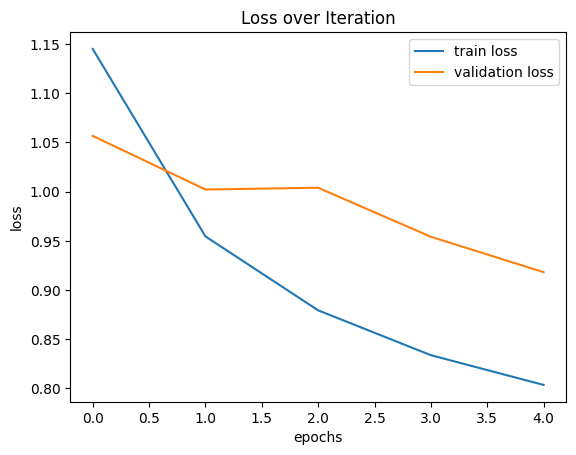


Starting epoch: 5

Epoch [6/40], Step [1/93], Loss: 0.6762
||||||||||||||||||||||||||||||||||||||||||||||||||||||

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [141]:
# hypengrparameter ** 91% idealmente
num_classes = 4
learning_rate = 0.00001 # 0.001
num_epochs = 40

model = CNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)


epoch_train_loss, epoch_val_loss = train(model,optimizer,loss_fn,num_epochs)

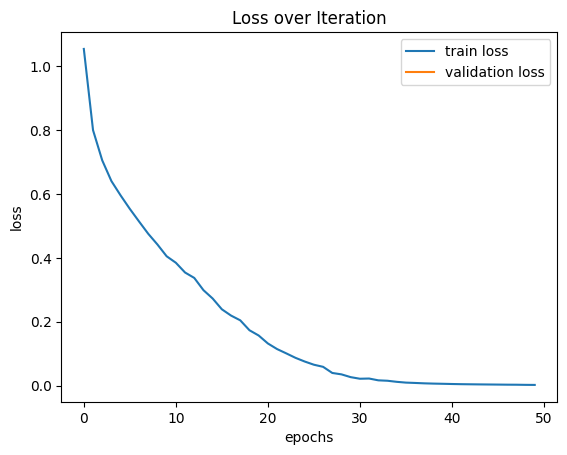

In [430]:
# main fig

plt.plot(range(len(epoch_train_loss)), epoch_train_loss, label="train loss")
plt.plot(range(len(epoch_val_loss)), epoch_val_loss, label="validation loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Loss over Iteration")
plt.legend(loc="upper right")


In [587]:
print((epoch_train_loss))
print("\n")
print((epoch_val_loss))

[0.7125638698009734, 0.7054034395420805, 0.696203664896336, 0.6878752264570682, 0.6873141495471305, 0.6809111732117673, 0.6718026291816792, 0.6699903334708924, 0.6600421286643819, 0.65463081192463, 0.6520892679691315, 0.6441589035886399, 0.6388493446593589, 0.6333320610066677, 0.6206435447043561, 0.6184543815064938, 0.6152039633152333, 0.612093706080254, 0.6052068960159382, 0.5952254254767235]


[0.7736320495605469, 0.7643654218741825, 0.7667407010282788, 0.7546370731932777, 0.7539844257490975, 0.76988314305033, 0.757445752620697, 0.7341245689562389, 0.7679276849542346, 0.7393179961613247, 0.7471502934183393, 0.7539207296712058, 0.7077036372252873, 0.7226038702896663, 0.7150306190763202, 0.7590835073164531, 0.7058191405875343, 0.7190213075705937, 0.6921520190579551, 0.7111957988568715]


In [176]:
# pre cache data from loader
i=0
print(N/batch_size)
for ((images, labels), (images_mask, labels_mask)) in (test_loader):
  print("|", end ="")
  i+=1

661.40625
|||

KeyboardInterrupt: 

In [137]:
with torch.no_grad():
      correct = 0
      total = 0
      # for images, labels in test_loader:
      for i, ((images, labels), (images_mask, labels_mask)) in enumerate(test_loader_small):
          # masked_images = images # without mask
          masked_images = torch.mul(images, images_mask) # with mask
          masked_images = masked_images.to(device)
          # images = images.to(device)

          labels = labels.to(device)
          outputs = model(masked_images)
          # outputs = model(images)
          # print(outputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          # print(correct, total)
          print("|", end ="")
      print('\nTest Accuracy of the model: {} %'.format(100 * correct / total))

|||||||||||||||||||||||||||||||||||||||||||||||||||||
Test Accuracy of the model: 67.80862374483166 %


In [510]:
print(100 * correct / total)

67.61229314420804


In [495]:
print(model)

# print(model.fc1.weight)


# Show_Weight(model.fc1.weight, 'fully connected 1: Weights')


CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=2704, out_features=4, bias=True)
  )
)


Label: 0


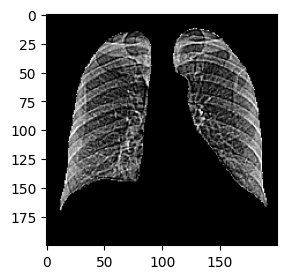

output: tensor([[-0.0427, -2.1861,  1.1781, -3.3167]])
image label: COVID
predicted label: Normal

MODEL VISUALIZATION

torch.Size([8, 1, 3, 3])
layer 1: Convolution weights


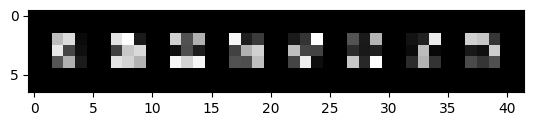

layer 1: Convolution output


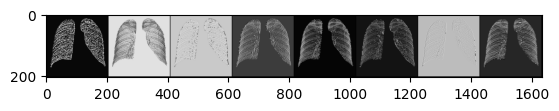

layer 1: Batch Norm


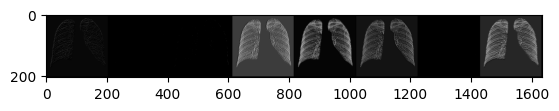

layer 1: ReLU


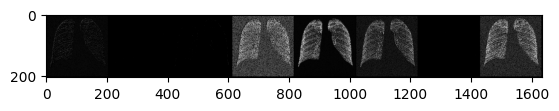

layer 1: Max-Pooling


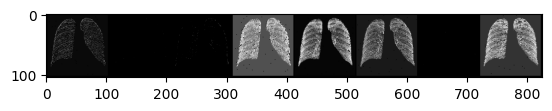

torch.Size([16, 8, 3, 3])
layer 2: Convolution output


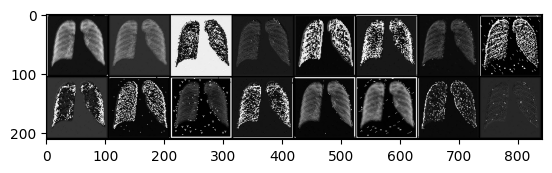

layer 2: Batch Norm


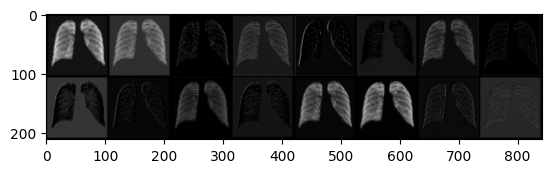

layer 2: ReLU


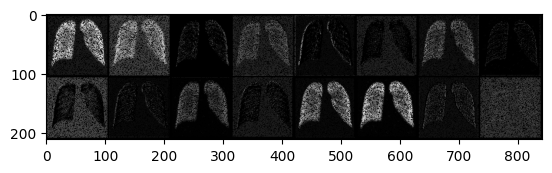

layer 2: Max-Pooling


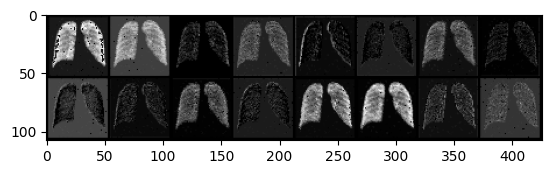

In [127]:
def Show(out, title = ''):
  print(title)
  out = out.permute(1,0,2,3)
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()

def Show_Weight(out, title = ''):
  print(title)
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()


with torch.no_grad():
  model.to('cpu')
  test_id = 102

  img, label = test_set[test_id] 
  img = img * test_set_mask[test_id][0] # apply mask
  Show_imgs(img, str(label))
  img = img.unsqueeze(0)
  out = model(img)
  print("output:", out)
  # print ((out == out.max()).nonzero())
  _, predicted = torch.max(out.data, 1)
  print("image label:", idx_to_class[label])
  print("predicted label:", idx_to_class[predicted[0].item()])
  
  print("\nMODEL VISUALIZATION\n")
  out = model.layer1[0](img)
  print(model.layer1[0].weight.shape)
  Show_Weight(model.layer1[0].weight, 'layer 1: Convolution weights')
  Show(out, 'layer 1: Convolution output')
  out = model.layer1[1](out)
  Show(out, 'layer 1: Batch Norm')
  out = model.layer1[2](out)
  Show(out, 'layer 1: ReLU')
  out = model.layer1[3](out)
  Show(out, 'layer 1: Max-Pooling')
    
  out = model.layer2[0](out)
  print(model.layer2[0].weight.shape)
  # Show_Weight(model.layer2[0].weight, 'layer 2: Convolution weights')
  Show(out, 'layer 2: Convolution output')
  out = model.layer2[1](out)
  Show(out, 'layer 2: Batch Norm')
  out = model.layer2[2](out)
  Show(out, 'layer 2: ReLU')
  out = model.layer2[3](out)
  Show(out, 'layer 2: Max-Pooling')
  model.to(device)

  

X
torch.Size([1, 1, 200, 200])
Y
torch.Size([1, 1, 198, 198])
Entrada
torch.Size([1, 1, 200, 200])
torch.Size([1, 1, 200, 200])


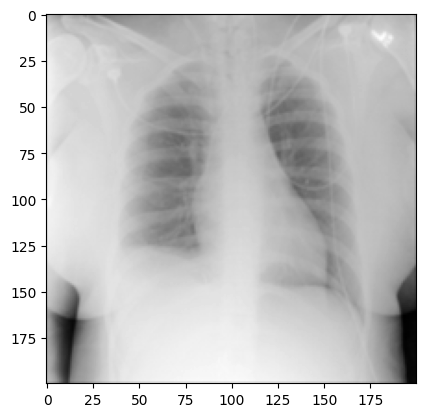

In [102]:
img, label = train_set[564]
plt.imshow(transforms.ToPILImage()(img), cmap = 'gray')
img = img.unsqueeze(0)

conv = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=5, stride=1, padding=1)
out = conv(img)

print("X")
print(img.shape)
print("Y")
print(out.shape)

conv2 = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=3, stride=1, padding=1)
conv3 = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=3, stride=1, padding=1)
out = conv2(img)
out = conv3(out)


print("Entrada")
print(img.shape)

print(out.shape)



In [103]:
print([ e.shape  for e in model.fc.parameters()])

model.fc.weight


[torch.Size([4, 76832]), torch.Size([4])]


Parameter containing:
tensor([[-0.0039, -0.0021,  0.0009,  ...,  0.0097,  0.0132,  0.0094],
        [ 0.0011,  0.0006, -0.0022,  ..., -0.0038, -0.0085, -0.0054],
        [-0.0009,  0.0010, -0.0005,  ..., -0.0068,  0.0036,  0.0038],
        [-0.0031,  0.0007, -0.0028,  ..., -0.0163, -0.0129, -0.0181]],
       requires_grad=True)